<a href="https://colab.research.google.com/github/Pythonash/Projects/blob/Brain/XAI_with_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 타이타닉 데이터셋 구축하기

- 내가(pythonash) 만든 tidy dataset으로, 타이타닉 생존자예측 top 5%를 달성하게 해준 데이터셋으로 진행한다.

- 코드를 실행함에 있어 모든 데이터셋의 기준이 될 예정이다. `필요시 추가`



In [13]:
#==========필요한 모듈 다운로드==========#
!pip install pdpbox
import pandas as pd
import numpy as np
import tensorflow as tf
from pdpbox import info_plots, pdp
#==========필요한 데이터셋 구축==========#
def build_setting():
  train_x = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/train_x.csv')
  val_x = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/val_x.csv')
  train_y = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/train_y.csv')
  val_y = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/val_y.csv')
  test_x = pd.read_csv('/content/drive/MyDrive/개인프로젝트/SHAP/test_x.csv')
  
  df_x = pd.concat([train_x, val_x],axis=0)
  df_y = pd.concat([train_y, val_y],axis=0)
  df = pd.concat([df_x, df_y], axis=1)
  #==========간단한 딥러닝 모델 구축==========#  
  deep_model = tf.keras.models.Sequential([
                                      tf.keras.layers.Input(shape = [len(df_x.columns)]),
                                      tf.keras.layers.Dense(8, activation = 'relu'),
                                      tf.keras.layers.Dense(8, activation = 'relu'),
                                      tf.keras.layers.Dense(8, activation = 'relu'),
                                      tf.keras.layers.Dense(8, activation = 'relu'),
                                      tf.keras.layers.Dense(1, activation = 'sigmoid')])
  deep_model.compile(loss = 'binary_crossentropy', metrics=['accuracy'], optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001))
  deep_model.fit(train_x, train_y, epochs =10, validation_data = (val_x, val_y))
  return df, df_x, df_y, test_x, deep_model

df, train_x, train_y, test_x, model = build_setting()

Epoch 1/10
23/23 [==============================] - 4s 57ms/step - loss: 0.6920 - accuracy: 0.5126 - val_loss: 0.6865 - val_accuracy: 0.5754
Epoch 2/10
23/23 [==============================] - 0s 11ms/step - loss: 0.6794 - accuracy: 0.6236 - val_loss: 0.6774 - val_accuracy: 0.6034
Epoch 3/10
23/23 [==============================] - 0s 8ms/step - loss: 0.6702 - accuracy: 0.6194 - val_loss: 0.6693 - val_accuracy: 0.6034
Epoch 4/10
23/23 [==============================] - 0s 14ms/step - loss: 0.6606 - accuracy: 0.6194 - val_loss: 0.6590 - val_accuracy: 0.6034
Epoch 5/10
23/23 [==============================] - 0s 17ms/step - loss: 0.6489 - accuracy: 0.6194 - val_loss: 0.6475 - val_accuracy: 0.6034
Epoch 6/10
23/23 [==============================] - 0s 15ms/step - loss: 0.6358 - accuracy: 0.6194 - val_loss: 0.6335 - val_accuracy: 0.6034
Epoch 7/10
23/23 [==============================] - 0s 12ms/step - loss: 0.6202 - accuracy: 0.6194 - val_loss: 0.6181 - val_accuracy: 0.6034
Epoch 8/10
23/

# 부분 의존성 플랏

- 피처의 `수치 변화에 따라 모델에 기여하는 정도`가 어떻게 달라지는지 확인 할 수 있는 XAI기법.

- 궁금한 피처가 `긍정/부정의 영향`을 미치는지 파악하게 해준다.

- 특정 피처에 대해 `버퍼존을 표시`해줌으로써 피쳐간 `독립성이 성립되지 않는 환경`에서 어느 정도 `모델에 오차`가 있을 수 있는지 확인하게 해준다.

- 피처 간 `종속관계가 있을 때에도 활용이 가능` 하다.

## info_plots.target_plot()

- 일단 이 모델은 `학습된 모델을 파라미터로 받지 않는다.`

- 이는 학습데이터를 분석해서 `모델이 어떻게 학습할 것인지 예상하는 XAI 기법`이다.

- 만약 `특정 피쳐의 데이터 구조가 편향`(남자 98%, 여자 2% 분포 등) 되어 있다면, 그 `데이터에 맞춰 결론이 왜곡`돼 있을 수 있다.

그렇다면, 모델을 뜯어보지 않아도 `어떤 편향으로 모델이 학습될지 파악가능`하다.

그리고 이러한 알고리즘을 구현해 놓은 것이 pdpbox 패키지 이다.

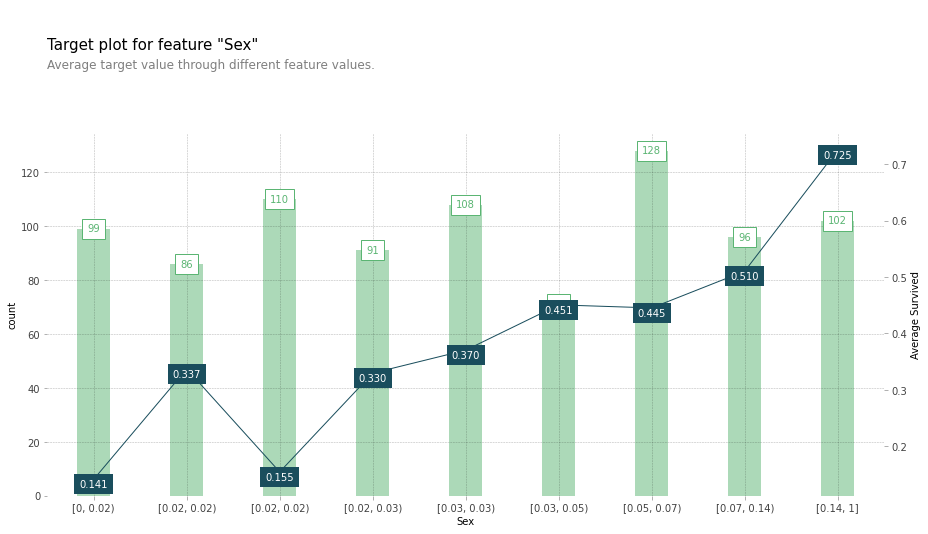

In [14]:
fig, axes, summary_df = info_plots.target_plot(
    df = df, # 피쳐 + 타겟 데이터
    feature = 'Fare', # 피쳐
    feature_name = 'Sex', # 표시할 이름
    target = 'Survived' # 타겟
)

`X 축은 피쳐`에 대한 정보, `왼쪽 Y축`은 각 수치 혹은 구간별 `데이터 수`, `오른쪽 Y축`은 `타겟(생존여부)에 대한 확률, 혹은 예상 값`이다.

`막대 그래프는 왼쪽 Y축`, `꺾은선 그래프는 오른쪽 Y축`에 대응한다.


이 그래프를 예로 들면, **Fare**의 경우(지금은 정규화 되어 0과 1사이의 값을 가짐) `0과 0.02` 사이에 속한 그룹은 데이터 개수는 99개, 이때 생존확률은 `14.1%`가 된다.

반대로, `0.14 ~ 1`사이에 속한 그룹의 경우 데이터 개수는 102개로 이때 생존 확률은 `72.5%`에 육박한다.



## 부분 의존성 플랏 결과 저장

- 결과를 DataFrame 포맷으로 저장한다.

In [ ]:
summary_df

,x,display_column,value_lower,value_upper,count,Survived
0,0,"[0, 0.02)",0.000000,0.015094,99,0.141414
1,1,"[0.02, 0.02)",0.015094,0.015412,86,0.337209
2,2,"[0.02, 0.02)",0.015412,0.016908,110,0.154545
3,3,"[0.02, 0.03)",0.016908,0.025374,91,0.329670
4,4,"[0.03, 0.03)",0.025374,0.032596,108,0.370370
5,5,"[0.03, 0.05)",0.032596,0.050749,71,0.450704
6,6,"[0.05, 0.07)",0.050749,0.068532,128,0.445312
7,7,"[0.07, 0.14)",0.068532,0.143462,96,0.510417
8,8,"[0.14, 1]",0.143462,1.000000,102,0.725490


# 예측 분포 플랏(prediction distribution plot)

- 데이터와 실제 모델을 결합해 두 결과가 일치하는지 확인 하는 방법

- 훈련된 모델을 집어넣었냐 아니냐에 따라 결과가 다르다.

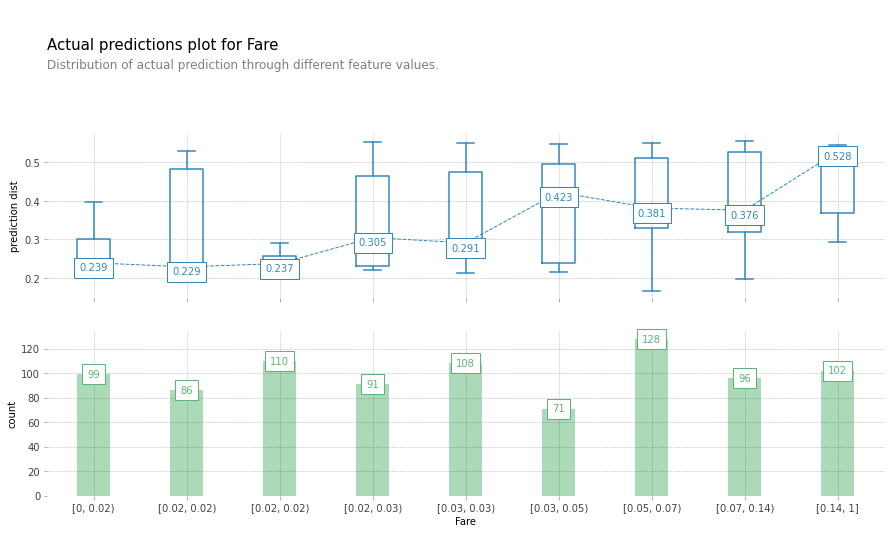

In [15]:
fig, axes, summary_df = info_plots.actual_plot(
    model = model, # 훈련된 모델 입력
    X = train_x, # 입력변수
    feature = 'Fare', # 보고자 하는 피쳐
    feature_name = 'Fare', # 피쳐 이름
    predict_kwds = {}
)

## 해석

위의 캔들스틱 차트는 `X의 구간별 예측 분포`를 나타낸다.

- 모델이 구간별로 예측한 값을 내놓고 있으며, 박스 안의 값(예를 들어, 첫 번째 캔들스틱의 0.469)은 평균적인 예측 확률이 된다.

- 구간에 따라 편차가 큰 것도 존재한다.

아래의 막대 그래프는 `x의 구간에 따른 데이터 개수 그래프`를 나타낸다.

> 이것으로 알 수 있는 것은, Fare의 경우 타이타닉 생존자의 확률을 예측하는데에 그렇게 중요한 변수는 아닐 수 있다는 것이다.

- 왜냐하면, Fare의 값이 커짐에 따라 우상향, 혹은 우하향 하는 추이도 보이지 않고 구간마다 예측 분포의 추이를 보면 값이 낮다고`(예를 들어, [0, 0.02])` 예측 편차가 작은 것도 아니며, 값이 크다고`([0.14, 1])` 예측 편차가 큰 것도 아니다.

그리고 이는 앞의 `info_plots.target_plot()`과는 다른 양상을 보여주고 있다.

Fare 구간 `[0, 0.02]`를 예로 들자면,

- `info_plots.target_plot()` 에서는 `평균 예측 확률이 14.1%`로 예상된다.

- `info_plots.actual_plot()` 에서는 `평균 예측 확률이 46.9%` 였다.



In [16]:
pdp_gc = pdp.pdp_isolate(
    model = model, # 모델
    dataset = df, # 전체 데이터셋 
    model_features = train_x.columns, # 컬럼 리스트 반환
    feature = 'Fare' # 보고자 하는 피쳐 입력
)